## ДЗ 3 ML in business

#### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по 1 месяцу.


2.Подберите параметры модели SARIMAX для этого ряда.


3.Сделайте вывод о том, как изменилась модель по сравнению с недельной.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [4]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [7]:
data_m = data.resample('M').mean()

In [9]:
data_m.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,32108.628796,2009.84000,6.420000,15.645434,2.475000,179.905434,26.140008,2.996992,11.499990,0.027135,0.026964,0.027152
std,3534.668371,4.82606,3.444258,1.084200,1.116066,104.903962,14.634509,0.115045,0.017667,0.022668,0.022522,0.022681
min,26314.458333,2002.00000,1.000000,1.530612,1.000000,16.000000,2.741935,2.530612,11.265306,0.000000,0.000000,0.000000
25%,29193.559812,2006.00000,3.000000,15.500000,1.000000,76.008748,11.702145,2.903226,11.500000,0.000000,0.000000,0.000000
50%,31879.175067,2010.00000,6.000000,16.000000,2.000000,167.500000,24.666667,3.000000,11.500000,0.032258,0.032258,0.032258
75%,34574.729839,2014.00000,9.000000,16.000000,3.000000,259.500000,37.800000,3.095967,11.500000,0.033621,0.033333,0.033621
max,40603.403226,2018.00000,12.000000,16.020188,4.000000,351.000000,51.000000,3.193548,11.515478,0.066759,0.066759,0.066759


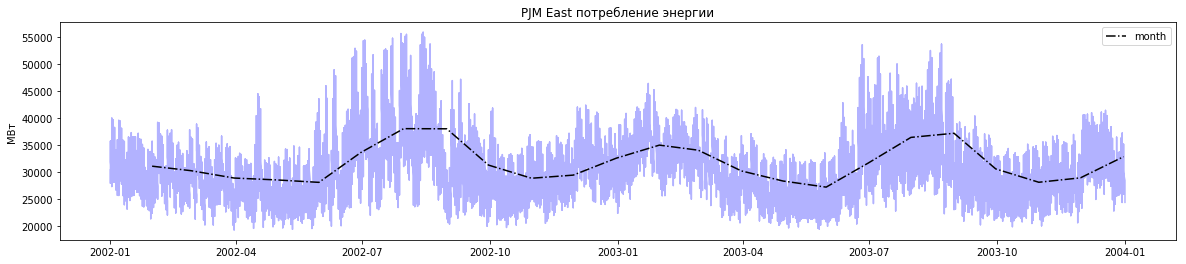

In [15]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:2*24*365], data['PJME_MW'].values[:2*24*365], 'b',alpha =0.3 )
plt.plot( data_m.index[:8*3], data_m['PJME_MW'].values[:8*3], '-.k',label='month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

На месячном ресемплинге явно видна сезонность. Тренд визуально не просматривается..

Посмотрим , что можно увидеть для модели (ACF, PACF)

In [19]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


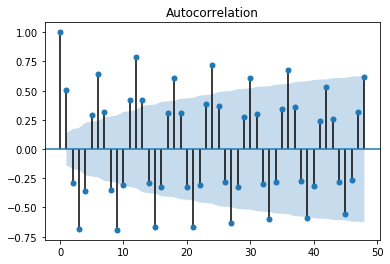

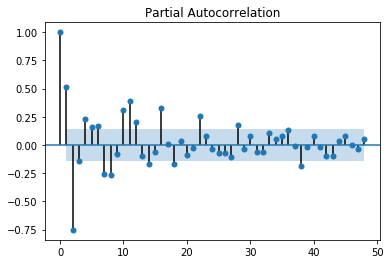

In [22]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=2*24)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=2*24)
plt.show()

Получили оценку автокорреляции месячной модели по иcходному ряду и его первым разностям. Для этой модели можно увидеть значительную автокорреляцию с лагом 12 месяцев и значительную корреляцию остатков по первым трем лагам (Partial Autocorrelation) с падением, но не нулевой корреляцией для лагов до 40 месяцев. Первый график говорит о параметре сезонности(12). По второму графику можно сказать, что есть нестационарность и необходимо ее отделить от нашего ряда.

Сохраняется корреляция для квартальных лагов (3, 6, 9 и 12 месяцы - это наши сезонные колебания - ACF) и для разностей важными являются значения внутри первых 3-х значений (PACF). Это позволит определить, что ряд сезонный и следует использовать модель сезонности с периодом 12, 6 или 3 месяца. диапазон поиска параметров модели ARIMA для лучшего описания нашего ряда в диапазоне до первых разностей и сглаживаний первого порядка. 

Рассмотрим результаты моделирования ряда с потенциально хорошими значениями порядками компонент нашего ряда с учетом сезонности в модификации SARIMAX, которая кроме всего прочего строит сезонную составляющую ряда. Фактически строим 3 модели : модель сезона и модель вокруг сезонных колебаний. А наш ряд очевидно сезонный. В качестве метрики качества используем информационный критерий Акаике (AIC) - чем меньше, тем лучше.

Обозначения для модели включают указание порядка для моделей AR (p), I (d) и MA (q) в качестве параметров функции ARIMA и AR (P), I (D), MA (Q) и m. параметры на сезонном уровне, например SARIMA (p, d, q) (P, D, Q) m, где «m» - количество временных шагов в каждом сезоне (сезонный период). Модель SARIMA может использоваться для разработки моделей AR, MA, ARMA и ARIMA. Принципиально формат обращения остается прежним (как у ARIMA), за исключением добавки сезонных параметров SARIMAX(<данные - массив ряда>,order=[p,d,q], seasonal_order=[ps,ds,qs])

In [27]:
import warnings

# Определим p, d и q 
q = 1
p = 2
d = 1 # Определили на предыдущем уроке, что ряд потребления энергии - интегрированный ряд первого порядка
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 12 месяцев
qs = 1
ps = 1
ds = 1
seasonal_pdq = [ps, ds, qs ,12] 


In [28]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [2, 1, 1]    : ps,ds,qs, S= [1, 1, 1, 12]


In [29]:
#для построения модели используем все данные, кроме 6 последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-6],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[2, 1, 1]x[1, 1, 1, 12] - AIC:2951.6128814027497


In [30]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  194
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1469.806
Date:                            Sun, 26 Apr 2020   AIC                           2951.613
Time:                                    16:41:58   BIC                           2970.321
Sample:                                         0   HQIC                          2959.206
                                            - 194                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Анализ результатов по results:
- коэффициенты при элементах модели имеют большие значения (особенно важны составляющие сглаживания coef: ar.L1, ma.L1 , ar.S.L12, ma.S.L12)
- можно посмотреть на остатки ряда (results.resid) с точки зрения автокорреляции и убедиться, что они не имеют значительной корреляции (это хорошо, т.к. остатки имеют характер белого шума)

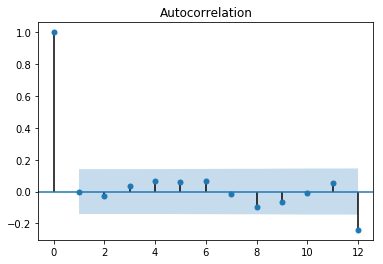

In [31]:
sm.graphics.tsa.plot_acf(results.resid, lags=12)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

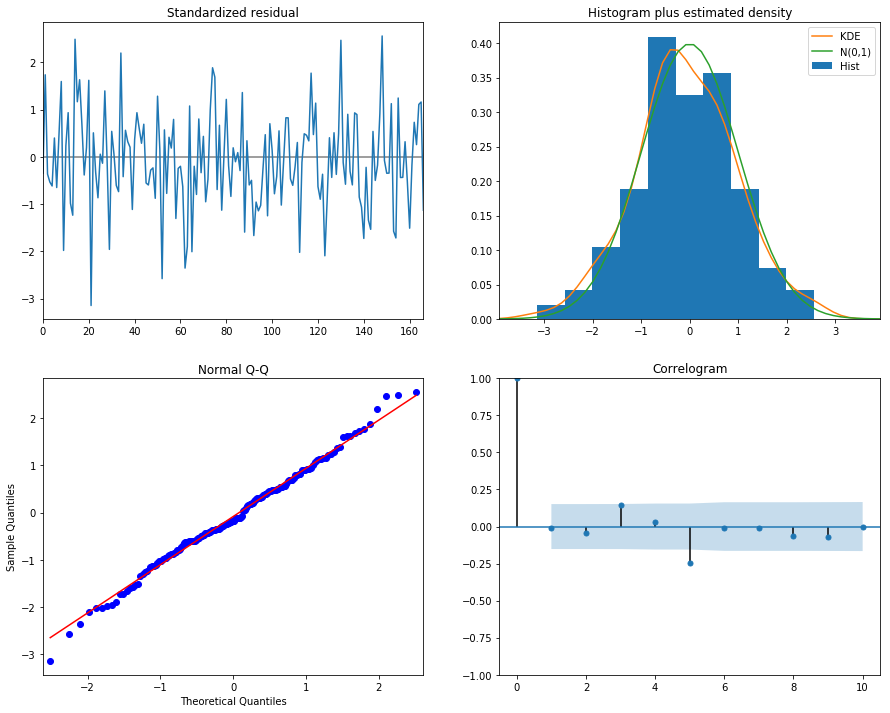

In [32]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


В этом случае диагностика показала, что остатки модели правильно распределяются:
- estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Очевидно, что остатки нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.
- Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже (работает долго!):

- На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда (для этой модели берем [0,3]).
    
- задаем длину сезона (здесь 12 месяцев)
    
- Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    
- Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    
- Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной модели.

In [33]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 1, 12)


In [34]:
data_m['PJME_MW'].values.shape

(200,)

In [39]:
len(data_m['PJME_MW'].values[:-6])

194

In [40]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-6],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:4557.429169986315
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:4152.164216678797
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3850.692029554881
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:3260.6519255466064
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:3033.819388303389
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2800.858337292362
ARIMA(0, 0, 1)x(0, 0, 0, 12)3 - AIC:4396.114581247948
ARIMA(0, 0, 1)x(0, 0, 1, 12)3 - AIC:4088.418793025383
ARIMA(0, 0, 1)x(0, 0, 2, 12)3 - AIC:3810.7168347267657
ARIMA(0, 0, 1)x(0, 1, 0, 12)3 - AIC:3218.687148074261
ARIMA(0, 0, 1)x(0, 1, 1, 12)3 - AIC:2994.3172947658554
ARIMA(0, 0, 1)x(0, 1, 2, 12)3 - AIC:2763.295986744489
ARIMA(0, 0, 2)x(0, 0, 0, 12)3 - AIC:4342.099066621355
ARIMA(0, 0, 2)x(0, 0, 1, 12)3 - AIC:4060.8260009779488
ARIMA(0, 0, 2)x(0, 0, 2, 12)3 - AIC:3788.5069289263547
ARIMA(0, 0, 2)x(0, 1, 0, 12)3 - AIC:3203.7788216211165
ARIMA(0, 0, 2)x(0, 1, 1, 12)3 - AIC:2978.6278446296583
ARIMA(0, 0, 2)x(0, 1, 2, 12)3 - AIC:2747.4809192467046
ARIMA(0, 1, 0)x(0, 0

ARIMA(2, 2, 1)x(0, 0, 1, 12)3 - AIC:3320.58891968083
ARIMA(2, 2, 1)x(0, 0, 2, 12)3 - AIC:3091.0698273249427
ARIMA(2, 2, 1)x(0, 1, 0, 12)3 - AIC:3268.650147847898
ARIMA(2, 2, 1)x(0, 1, 1, 12)3 - AIC:2987.751272539501
ARIMA(2, 2, 1)x(0, 1, 2, 12)3 - AIC:2742.272564516535
ARIMA(2, 2, 2)x(0, 0, 0, 12)3 - AIC:3444.624276668691
ARIMA(2, 2, 2)x(0, 0, 1, 12)3 - AIC:3221.625491878643
ARIMA(2, 2, 2)x(0, 0, 2, 12)3 - AIC:3008.281614383051
ARIMA(2, 2, 2)x(0, 1, 0, 12)3 - AIC:3247.9946306371794
ARIMA(2, 2, 2)x(0, 1, 1, 12)3 - AIC:2957.1291530841345
ARIMA(2, 2, 2)x(0, 1, 2, 12)3 - AIC:2745.471974358652


Лучшие результаты на недельных данных параметры модели SARIMA(0, 1, 2)x(0, 1, 2, 12) - AIC:2717.03 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

In [41]:
#для построения модели используем все данные, кроме 6 последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-6],order=[0,1,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)


AIC:{} 2717.032252472957


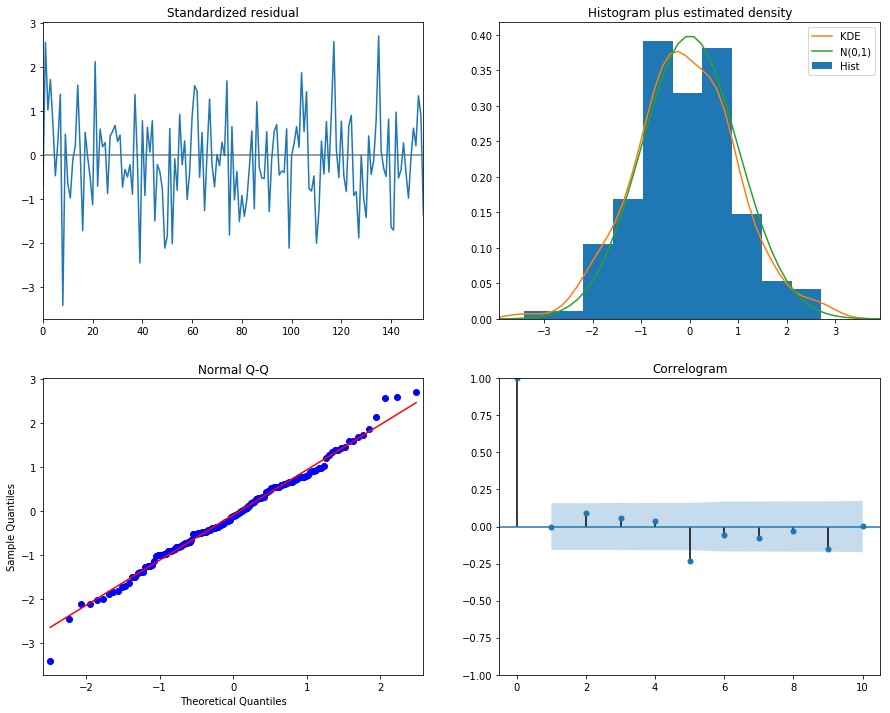

In [44]:
results_opt.plot_diagnostics(figsize=(15, 12))
plt.show()


Проведем моделирование прогноза на основе найденой SARIMAX(0, 1, 2)x(0, 1, 2, 12) - AIC:2717.03 и модели  SARIMAX[2, 1, 1]x[1, 1, 1, 12] - AIC:2951.61 для последних 6 месяцев(и предсказание следующих 12 )  и сравним их с фактом.

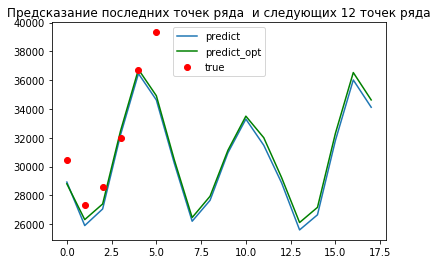

In [43]:
pred_dynamic = results.forecast(18)    #делаем предсказание на 12 точек от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(18)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-6:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()

plt.show()

Видно, что предсказание новых точек тем слабее, чем дальше от последней известной точки ряда. Это можно объяснить тем, что накапливается ошибка предсказания или изменились условия развития ряда. Модель, которую выбрали по сетке, примерно также обходит точки известные нам заранее и в целом очень похожа на изначально подобранную. Таким образом, изначальный выбор был недалек от наилучшего и подбор это подтвердил, хотя и позволил немного улучшить исходный результат для ряда с сезонами и циклами.

Сравнение с недельной моделью:

In [23]:
data_w = data.resample('W').mean()

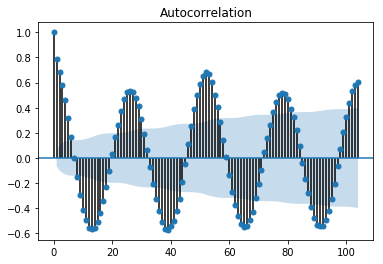

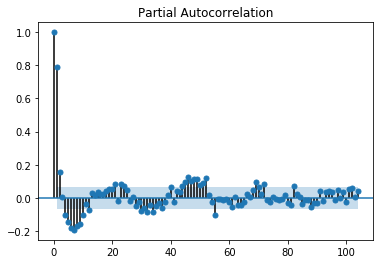

In [26]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=2*52)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=2*52)
plt.show()

У недельной модели очень выражен еще одтн уровень сезонности (полугодовая или годовая). 
Оптимальные параметры SARIMAX для недельного ряда существенно отличаются от ряда по месяцам. 



#### 4. Возьмите вариант 1 или 2


- Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

- Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )


5.Оцените результат моделирования


6.Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [45]:


path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [47]:
brent_data_m = brent_data.resample('M').mean()
brent_data_m.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-30,78.228148,2010.0,9.0,15.185185,3.0,258.185185,36.925926,2.703704,0.037037,0.037037,0.037037
2010-10-31,83.473462,2010.0,10.0,16.000000,4.0,289.000000,41.307692,2.846154,0.038462,0.038462,0.038462
2010-11-30,86.178077,2010.0,11.0,15.346154,4.0,319.346154,45.692308,2.500000,0.076923,0.076923,0.076923
2010-12-31,92.232308,2010.0,12.0,16.384615,4.0,350.384615,50.115385,2.576923,0.076923,0.076923,0.000000
2011-01-31,97.033200,2011.0,1.0,16.680000,1.0,16.680000,4.640000,2.760000,0.040000,0.040000,0.040000


In [48]:
brent_data_m.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,80.571077,2014.706422,6.522936,15.580231,2.504587,182.965552,26.498416,2.552969,0.027625,0.035238,0.029531
std,26.667645,2.657285,3.460348,1.514704,1.119059,105.204359,14.780596,0.434195,0.026652,0.097607,0.027119
min,31.984737,2010.000000,1.000000,1.000000,1.000000,15.625000,2.421053,1.863636,0.000000,0.000000,0.000000
25%,57.264074,2012.000000,4.000000,15.346154,2.000000,105.192308,15.304348,2.481481,0.000000,0.000000,0.000000
50%,75.704800,2015.000000,7.000000,15.761905,3.000000,196.777778,28.307692,2.629630,0.037037,0.037037,0.037037
75%,108.559167,2017.000000,9.000000,16.074074,3.000000,260.045455,37.909091,2.703704,0.041667,0.040000,0.043478
max,124.502308,2019.000000,12.000000,17.280000,4.000000,350.840000,50.954545,6.000000,0.095238,1.000000,0.095238


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

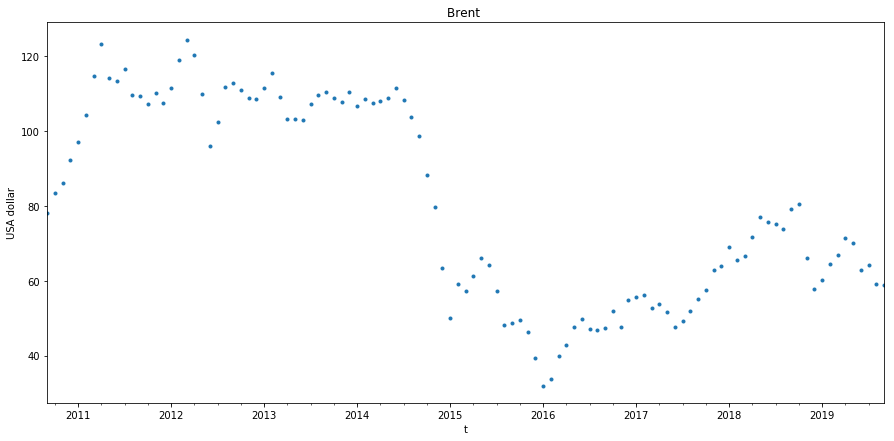

In [51]:
_ = brent_data_m['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Повторим процесс для второго ряда "Цена нефти Brent". Нет сезонности, есть интегральность, есть изменяющиеся во времени тенденции.

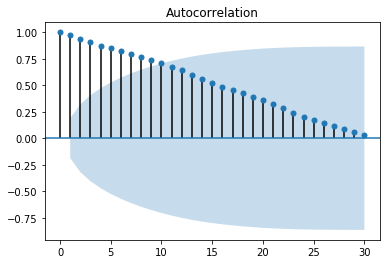

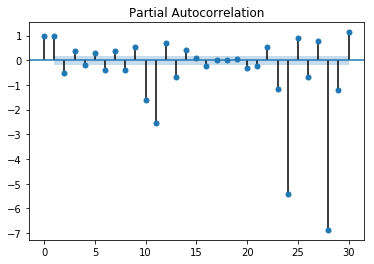

In [52]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(brent_data_m['Значение'].values, lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_data_m['Значение'].values, lags=30)
plt.show()

Дневные графики показывают автокорреляцию цены с первыми 11 значениями (это много) и на PACF мы видим, что 1-е 2 порядка разностей важны для нашего процесса, и далее по вскму ряду идут важные для процесса разности.

Вывод - для данного ряда ARIMA не очень применима, в связи с отсутствием автокорреляции.